In [2]:
from sklearn.datasets import load_iris 
import numpy as np
from IrisFisher import softmax, logloss, sigmoid
import matplotlib.pyplot as plt
from seaborn import pairplot
from pandas import DataFrame
from IrisFisher import MinMaxNormalizer

In [3]:
data = load_iris()

In [4]:
def UnisonShuffle(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]    
    
def test_train_split_good(*arrays, **params):
    len_n = len(arrays)
    
    shuffle = params.pop('shuffle', False)
    
def test_train_split(X, y, **options):
    
    lenX = len(X)
    
    shuffle = options.pop('shuffle', False)
    test_size = options.pop('test_size', 0.1)
    
    if shuffle:
        X, y = UnisonShuffle(X, y)
    
    test_elems = np.random.choice(lenX, int(lenX * test_size), replace=False)
    test_mask = np.zeros(lenX, dtype=bool)
    test_mask[test_elems] = True
    
    return X[~test_mask], y[~test_mask], X[test_mask], y[test_mask] 

In [38]:
def count_accuracy(X, y, params):
    error_counter = 0
    for iter, item in enumerate(y):
        X_cur = X[iter]
        y_cur = y[iter]
        forward_prop_1(X_cur, y_cur, params)
        if np.argmax(y_cur) != np.argmax(params["P2"]):
            error_counter += 1
    return (len(y) - error_counter)/len(y)

#Doesn't work 
def softmax_grad_2(x):
    # I don't know how to make dot product along first axes. Like [2, 3] and [3, 2] to [2, 3, 3]
    # Can be implemented in loop, but i don't want
    Id = np.eye(x.shape[-1])
    return x[..., np.newaxis] * Id

def forward_prop_1(X, y, params):
    params["L0"] = X

    params["L1"] = np.dot(params["L0"], params["W0"]) + params["b0"]
    params["P1"] = sigmoid(params["L1"])

    # params["P1"] = X

    params["L2"] = np.dot(params["P1"], params["W1"]) + params["b1"]
    params["P2"] = softmax(params["L2"])

    params["E"] = logloss(params["P2"], y)

def back_prop_2(X, y, params, giper_params):
    
    #Can simplify it to 
    # params["dE/dP2"] = - y / params["P2"]  # 1x3
    # params["dP2/dL2"] = softmax_grad_2(params["P2"])  # 3x3
    # params["dE/dL2"] = np.dot(params["dE/dP2"], params["dP2/dL2"])  # 1x3
    # to 
    params["dE/dL2"] = params["P2"] - y
    
    params["dE/dW1"] = np.dot(params["P1"].T, params["dE/dL2"])  # 4x3
    params["dE/db1"] = np.sum(params["dE/dL2"], axis=0)

    params["dE/dP1"] = np.dot(params["dE/dL2"], params["W1"].T)  # 1x4
    params["dP1/dL1"] = params["P1"] * (1 - params["P1"])  # 1x4
    params["dE/dL1"] = params["dE/dP1"] * params["dP1/dL1"]  # 1x4
    params["dE/dW0"] = np.dot(params["L0"].T, params["dE/dL1"])  # 4x4
    params["dE/db0"] = np.sum(params["dE/dL1"], axis=0)
    print(params["W1"])

    params["W1"] -= giper_params["learning rate"] * params["dE/dW1"]
    params["b1"] -= giper_params["learning rate"] * params["dE/db1"]

    params["W0"] -= giper_params["learning rate"] * params["dE/dW0"]
    params["b0"] -= giper_params["learning rate"] * params["dE/db0"]

In [39]:
X = data["data"]
y_lables = data["target"]

All_len = len(X)

y = np.zeros((len(y_lables), 3))
for i, a in enumerate(y_lables):
    y[i][a] = 1

df= DataFrame(X)
df["labels"] = y_lables

X = X.reshape(-1, 4)
y = y.reshape(-1, 3)

In [48]:
TEST_SIZE = 30

test_len = TEST_SIZE
train_len = All_len - test_len

# np.random.seed(1)
X_train, y_train, X_test, y_test = test_train_split(X, y, shuffle=True, test_size=(test_len/All_len))

In [51]:
from IrisFisher import net_init_1

#strart from here 
normalizer = MinMaxNormalizer()
X_train = normalizer.fit_and_normalize(X_train)
X_test = normalizer.normalize(X_test)


params = dict()

giper_params = dict()
giper_params["learning rate"] = 0.001
giper_params["batch size"] = 10

lenX = len(y)

net_init_1(params)

[[-0.1 -0.1 -0.1]
 [-0.1 -0.1 -0.1]
 [-0.1 -0.1 -0.1]
 [-0.1 -0.1 -0.1]]
[[-0.08239312 -0.08332019 -0.08284806]
 [-0.08239312 -0.08332019 -0.08284806]
 [-0.08239312 -0.08332019 -0.08284806]
 [-0.08239312 -0.08332019 -0.08284806]]
[[-0.06483532 -0.06669397 -0.06575759]
 [-0.06483532 -0.06669397 -0.06575759]
 [-0.06483532 -0.06669397 -0.06575759]
 [-0.06483532 -0.06669397 -0.06575759]]
[[-0.04731816 -0.05011205 -0.04871798]
 [-0.04731816 -0.05011205 -0.04871798]
 [-0.04731816 -0.05011205 -0.04871798]
 [-0.04731816 -0.05011205 -0.04871798]]
[[-0.02983324 -0.03356521 -0.03171875]
 [-0.02983324 -0.03356521 -0.03171875]
 [-0.02983324 -0.03356521 -0.03171875]
 [-0.02983324 -0.03356521 -0.03171875]]
[[-0.01237221 -0.01704427 -0.01474944]
 [-0.01237221 -0.01704427 -0.01474944]
 [-0.01237221 -0.01704427 -0.01474944]
 [-0.01237221 -0.01704427 -0.01474944]]
[[ 0.00507322 -0.00054011  0.00220034]
 [ 0.00507322 -0.00054011  0.00220034]
 [ 0.00507322 -0.00054011  0.00220034]
 [ 0.00507322 -0.00054011

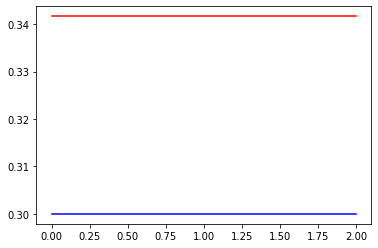

In [52]:
test_accuracy = []
train_accuracy = []
time = []

for i in range(400):
    X_cur = X_train
    y_cur = y_train
    forward_prop_1(X_cur, y_cur, params)
    back_prop_2(X_cur, y_cur, params, giper_params)
    if (i % train_len) == train_len - 1:
        time.append(i // train_len)
    
        test_accuracy.append(count_accuracy(X_test, y_test, params))
        train_accuracy.append(count_accuracy(X_train, y_train, params))
    
plt.plot(time, train_accuracy, "r")
plt.plot(time, test_accuracy, "b")
plt.show()